In [ ]:
!git clone https://github.com/rishabh-bhardwaj-64rr/EVA5.git

fatal: destination path 'EVA5' already exists and is not an empty directory.


In [ ]:
pwd

'/content'

In [ ]:
cd EVA5/S12/

/content/EVA5/S12


In [ ]:
!git pull

Already up to date.


In [ ]:
from __future__ import print_function

import matplotlib.pyplot as plt

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
from torchvision import datasets, transforms
from torchsummary import summary

from tqdm import tqdm

import albumentations as A
import albumentations.pytorch.transforms as APT

In [ ]:
from data_loading import transform, dataset, dataloader, util
from data_loading.dataloader import TinyImageNetDataLoader
from models import resnet
from utils import plot_metrics, misclassifications, classwise_accuracy, show_image
from essentials.lr_finder import LRFinder
import trainer, tester, run_model
from gradcam import run_grad_cam

In [ ]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-dc486c0b-0b37-7d6c-2ee1-4651965ead1d)


In [ ]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
data_dir = '/content/EVA5/S12/data/'

In [ ]:
train_transforms, test_transforms = transform.tinyimagenet_albumentations(mean, std)
# trainset, testset = TinyImageNet(train_transforms, test_transforms)
tin = TinyImageNetDataLoader(train_transforms=train_transforms, test_transforms=test_transforms,
                                data_dir = data_dir, batch_size=512, shuffle=True, num_workers=8, pin_memory=True)
train_loader, test_loader = tin.get_loaders()
# ToTensorV2()

Done.


In [ ]:
# device
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


In [ ]:
# model summary
net = resnet.ResNet18_TinyImageNet().to(device)
print(summary(net, input_size=(3, 64, 64)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,728
       BatchNorm2d-2           [-1, 64, 64, 64]             128
            Conv2d-3           [-1, 64, 64, 64]          36,864
       BatchNorm2d-4           [-1, 64, 64, 64]             128
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
        BasicBlock-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
           Conv2d-10           [-1, 64, 64, 64]          36,864
      BatchNorm2d-11           [-1, 64, 64, 64]             128
       BasicBlock-12           [-1, 64, 64, 64]               0
           Conv2d-13          [-1, 128, 32, 32]          73,728
      BatchNorm2d-14          [-1, 128,


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.12E-02


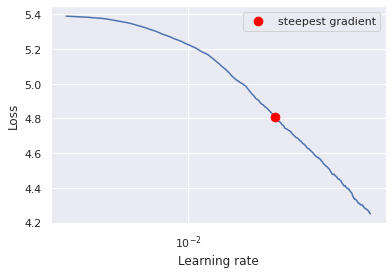

0.05


In [ ]:

optimizer = optim.SGD(net.parameters(), lr=0.01,  momentum=0.9)
criterion = nn.CrossEntropyLoss()

lr_finder = LRFinder(net, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, start_lr=1e-3, end_lr=0.05, num_iter=200, step_mode='linear')

lr_finder.plot() # loss vs lr curve

best_lr = lr_finder.history['lr'][lr_finder.history['loss'].index(lr_finder.best_loss)]
print(best_lr)

lr_finder.reset()

In [ ]:

EPOCHS = 50
max_lr_epoch = 6
optimizer = optim.SGD(net.parameters(), lr = 0.01, momentum = 0.9)
pct_start = max_lr_epoch/EPOCHS
scheduler = OneCycleLR(optimizer=optimizer, max_lr=best_lr, epochs=EPOCHS, steps_per_epoch=len(train_loader), pct_start=pct_start,anneal_strategy='cos', div_factor=10, final_div_factor=1)

train_acc = []
train_losses = []
test_acc = []
test_losses = []

run_model.evaluation( net, train_loader, test_loader, optimizer, scheduler, EPOCHS, device,
                    train_acc, train_losses, test_acc, test_losses)

  0%|          | 0/151 [00:00<?, ?it/s]


 Epoch: 1


Loss = 4.276063919067383 Batch_id = 150 Accuracy = 5.10: 100%|██████████| 151/151 [02:15<00:00,  1.11it/s]
  0%|          | 0/65 [00:00<?, ?it/s]


LR from scheduler: [0.008020940500289064]


Loss = 4.630583763122559 Batch_id = 64 Accuracy = 7.17: 100%|██████████| 65/65 [00:20<00:00,  3.18it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0089, Accuracy: 2367/33000 (7.17%)


 Epoch: 2


Loss = 3.7586758136749268 Batch_id = 150 Accuracy = 12.02: 100%|██████████| 151/151 [02:15<00:00,  1.11it/s]
  0%|          | 0/65 [00:00<?, ?it/s]


LR from scheduler: [0.01627255475615299]


Loss = 3.976158380508423 Batch_id = 64 Accuracy = 13.89: 100%|██████████| 65/65 [00:20<00:00,  3.20it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0078, Accuracy: 4584/33000 (13.89%)


 Epoch: 3


Loss = 3.6251871585845947 Batch_id = 150 Accuracy = 18.53: 100%|██████████| 151/151 [02:15<00:00,  1.11it/s]
  0%|          | 0/65 [00:00<?, ?it/s]


LR from scheduler: [0.02753905292774272]


Loss = 3.415955066680908 Batch_id = 64 Accuracy = 18.16: 100%|██████████| 65/65 [00:20<00:00,  3.20it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0072, Accuracy: 5993/33000 (18.16%)


 Epoch: 4


Loss = 3.0884039402008057 Batch_id = 150 Accuracy = 23.80: 100%|██████████| 151/151 [02:15<00:00,  1.11it/s]
  0%|          | 0/65 [00:00<?, ?it/s]


LR from scheduler: [0.038795064293014866]


Loss = 3.7105464935302734 Batch_id = 64 Accuracy = 19.32: 100%|██████████| 65/65 [00:20<00:00,  3.23it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0075, Accuracy: 6375/33000 (19.32%)


 Epoch: 5


Loss = 2.994288921356201 Batch_id = 150 Accuracy = 28.45: 100%|██████████| 151/151 [02:15<00:00,  1.11it/s]
  0%|          | 0/65 [00:00<?, ?it/s]


LR from scheduler: [0.047018034131519226]


Loss = 3.451380729675293 Batch_id = 64 Accuracy = 25.87: 100%|██████████| 65/65 [00:20<00:00,  3.17it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0064, Accuracy: 8538/33000 (25.87%)


 Epoch: 6


Loss = 2.8866775035858154 Batch_id = 150 Accuracy = 32.61: 100%|██████████| 151/151 [02:15<00:00,  1.11it/s]
  0%|          | 0/65 [00:00<?, ?it/s]


LR from scheduler: [0.04999999748468134]


Loss = 2.9552435874938965 Batch_id = 64 Accuracy = 29.26: 100%|██████████| 65/65 [00:20<00:00,  3.22it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0061, Accuracy: 9656/33000 (29.26%)


 Epoch: 7


Loss = 2.8679800033569336 Batch_id = 150 Accuracy = 35.87: 100%|██████████| 151/151 [02:15<00:00,  1.11it/s]
  0%|          | 0/65 [00:00<?, ?it/s]


LR from scheduler: [0.049941911088856955]


Loss = 3.12705397605896 Batch_id = 64 Accuracy = 30.55: 100%|██████████| 65/65 [00:20<00:00,  3.22it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0059, Accuracy: 10081/33000 (30.55%)


 Epoch: 8


Loss = 2.4980409145355225 Batch_id = 150 Accuracy = 39.28: 100%|██████████| 151/151 [02:15<00:00,  1.12it/s]
  0%|          | 0/65 [00:00<?, ?it/s]


LR from scheduler: [0.04976946585826999]


Loss = 2.918754816055298 Batch_id = 64 Accuracy = 31.63: 100%|██████████| 65/65 [00:20<00:00,  3.22it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0059, Accuracy: 10438/33000 (31.63%)


 Epoch: 9


Loss = 2.5837738513946533 Batch_id = 150 Accuracy = 41.54: 100%|██████████| 151/151 [02:15<00:00,  1.11it/s]
  0%|          | 0/65 [00:00<?, ?it/s]


LR from scheduler: [0.04948354053428753]


Loss = 3.127070426940918 Batch_id = 64 Accuracy = 31.81: 100%|██████████| 65/65 [00:20<00:00,  3.20it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0059, Accuracy: 10496/33000 (31.81%)


 Epoch: 10


Loss = 2.335373640060425 Batch_id = 150 Accuracy = 44.33: 100%|██████████| 151/151 [02:15<00:00,  1.11it/s]
  0%|          | 0/65 [00:00<?, ?it/s]


LR from scheduler: [0.04908559212682066]


Loss = 2.865628719329834 Batch_id = 64 Accuracy = 36.37: 100%|██████████| 65/65 [00:20<00:00,  3.21it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0054, Accuracy: 12001/33000 (36.37%)


 Epoch: 11


Loss = 2.355430841445923 Batch_id = 150 Accuracy = 46.26: 100%|██████████| 151/151 [02:15<00:00,  1.11it/s]
  0%|          | 0/65 [00:00<?, ?it/s]


LR from scheduler: [0.04857764848973587]


Loss = 2.5776753425598145 Batch_id = 64 Accuracy = 36.66: 100%|██████████| 65/65 [00:20<00:00,  3.21it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0054, Accuracy: 12097/33000 (36.66%)


 Epoch: 12


Loss = 2.031308174133301 Batch_id = 150 Accuracy = 48.44: 100%|██████████| 151/151 [02:15<00:00,  1.11it/s]
  0%|          | 0/65 [00:00<?, ?it/s]


LR from scheduler: [0.047962297987376674]


Loss = 2.3712775707244873 Batch_id = 64 Accuracy = 42.65: 100%|██████████| 65/65 [00:20<00:00,  3.21it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0047, Accuracy: 14076/33000 (42.65%)


 Epoch: 13


Loss = 1.8647816181182861 Batch_id = 150 Accuracy = 50.10: 100%|██████████| 151/151 [02:15<00:00,  1.11it/s]
  0%|          | 0/65 [00:00<?, ?it/s]


LR from scheduler: [0.04724267630485213]


Loss = 2.67572283744812 Batch_id = 64 Accuracy = 40.39: 100%|██████████| 65/65 [00:20<00:00,  3.23it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0050, Accuracy: 13329/33000 (40.39%)


 Epoch: 14


Loss = 2.211920976638794 Batch_id = 150 Accuracy = 51.97: 100%|██████████| 151/151 [02:15<00:00,  1.11it/s]
  0%|          | 0/65 [00:00<?, ?it/s]


LR from scheduler: [0.04642245046930432]


Loss = 2.287515878677368 Batch_id = 64 Accuracy = 41.11: 100%|██████████| 65/65 [00:20<00:00,  3.20it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0050, Accuracy: 13565/33000 (41.11%)


 Epoch: 15


Loss = 1.8758586645126343 Batch_id = 150 Accuracy = 54.24: 100%|██████████| 151/151 [02:15<00:00,  1.11it/s]
  0%|          | 0/65 [00:00<?, ?it/s]


LR from scheduler: [0.045505800163578636]


Loss = 2.2514290809631348 Batch_id = 64 Accuracy = 44.22: 100%|██████████| 65/65 [00:20<00:00,  3.21it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0047, Accuracy: 14593/33000 (44.22%)


 Epoch: 16


Loss = 1.7702637910842896 Batch_id = 150 Accuracy = 55.53: 100%|██████████| 151/151 [02:15<00:00,  1.11it/s]
  0%|          | 0/65 [00:00<?, ?it/s]


LR from scheduler: [0.044497396427517995]


Loss = 2.514566659927368 Batch_id = 64 Accuracy = 45.17: 100%|██████████| 65/65 [00:20<00:00,  3.20it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 14907/33000 (45.17%)


 Epoch: 17


Loss = 1.6999386548995972 Batch_id = 150 Accuracy = 57.18: 100%|██████████| 151/151 [02:15<00:00,  1.12it/s]
  0%|          | 0/65 [00:00<?, ?it/s]


LR from scheduler: [0.04340237785541456]


Loss = 2.364621639251709 Batch_id = 64 Accuracy = 45.50: 100%|██████████| 65/65 [00:20<00:00,  3.23it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 15015/33000 (45.50%)


 Epoch: 18


Loss = 1.615010380744934 Batch_id = 150 Accuracy = 58.78: 100%|██████████| 151/151 [02:15<00:00,  1.11it/s]
  0%|          | 0/65 [00:00<?, ?it/s]


LR from scheduler: [0.04222632441091104]


Loss = 2.437878370285034 Batch_id = 64 Accuracy = 43.11: 100%|██████████| 65/65 [00:20<00:00,  3.22it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0050, Accuracy: 14226/33000 (43.11%)


 Epoch: 19


Loss = 1.4200609922409058 Batch_id = 150 Accuracy = 60.46: 100%|██████████| 151/151 [02:15<00:00,  1.11it/s]
  0%|          | 0/65 [00:00<?, ?it/s]


LR from scheduler: [0.040975228992785065]


Loss = 2.0836634635925293 Batch_id = 64 Accuracy = 46.97: 100%|██████████| 65/65 [00:20<00:00,  3.19it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 15501/33000 (46.97%)


 Epoch: 20


Loss = 1.419561743736267 Batch_id = 150 Accuracy = 61.48: 100%|██████████| 151/151 [02:15<00:00,  1.11it/s]
  0%|          | 0/65 [00:00<?, ?it/s]


LR from scheduler: [0.039655466896510685]


Loss = 2.347191572189331 Batch_id = 64 Accuracy = 48.34: 100%|██████████| 65/65 [00:20<00:00,  3.21it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 15951/33000 (48.34%)


 Epoch: 21


Loss = 1.2152212858200073 Batch_id = 150 Accuracy = 63.22: 100%|██████████| 151/151 [02:15<00:00,  1.11it/s]
  0%|          | 0/65 [00:00<?, ?it/s]


LR from scheduler: [0.038273763327213974]


Loss = 2.421719551086426 Batch_id = 64 Accuracy = 47.05: 100%|██████████| 65/65 [00:20<00:00,  3.21it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 15528/33000 (47.05%)


 Epoch: 22


Loss = 1.1268751621246338 Batch_id = 150 Accuracy = 65.01: 100%|██████████| 151/151 [02:15<00:00,  1.11it/s]
  0%|          | 0/65 [00:00<?, ?it/s]


LR from scheduler: [0.036837159129569266]


Loss = 2.254267692565918 Batch_id = 64 Accuracy = 47.64: 100%|██████████| 65/65 [00:20<00:00,  3.21it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 15722/33000 (47.64%)


 Epoch: 23


Loss = 1.455772042274475 Batch_id = 150 Accuracy = 66.51: 100%|██████████| 151/151 [02:15<00:00,  1.11it/s]
  0%|          | 0/65 [00:00<?, ?it/s]


LR from scheduler: [0.03535297490926863]


Loss = 2.323340892791748 Batch_id = 64 Accuracy = 47.39: 100%|██████████| 65/65 [00:20<00:00,  3.19it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 15639/33000 (47.39%)


 Epoch: 24


Loss = 1.234550952911377 Batch_id = 150 Accuracy = 67.86: 100%|██████████| 151/151 [02:15<00:00,  1.11it/s]
  0%|          | 0/65 [00:00<?, ?it/s]


LR from scheduler: [0.033828773728893244]


Loss = 2.0370311737060547 Batch_id = 64 Accuracy = 48.36: 100%|██████████| 65/65 [00:20<00:00,  3.22it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 15958/33000 (48.36%)


 Epoch: 25


Loss = 1.0686010122299194 Batch_id = 150 Accuracy = 69.33: 100%|██████████| 151/151 [02:15<00:00,  1.11it/s]
  0%|          | 0/65 [00:00<?, ?it/s]


LR from scheduler: [0.032272322568280144]


Loss = 2.462245464324951 Batch_id = 64 Accuracy = 49.85: 100%|██████████| 65/65 [00:20<00:00,  3.21it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 16452/33000 (49.85%)


 Epoch: 26


Loss = 1.1811541318893433 Batch_id = 150 Accuracy = 70.41: 100%|██████████| 151/151 [02:15<00:00,  1.12it/s]
  0%|          | 0/65 [00:00<?, ?it/s]


LR from scheduler: [0.030691552745773294]


Loss = 2.3444321155548096 Batch_id = 64 Accuracy = 49.49: 100%|██████████| 65/65 [00:20<00:00,  3.21it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 16332/33000 (49.49%)


 Epoch: 27


Loss = 1.0971113443374634 Batch_id = 150 Accuracy = 72.21: 100%|██████████| 151/151 [02:15<00:00,  1.12it/s]
  0%|          | 0/65 [00:00<?, ?it/s]


LR from scheduler: [0.02909451950204332]


Loss = 2.0287647247314453 Batch_id = 64 Accuracy = 50.38: 100%|██████████| 65/65 [00:20<00:00,  3.18it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 16624/33000 (50.38%)


 Epoch: 28


Loss = 0.967333972454071 Batch_id = 150 Accuracy = 73.98: 100%|██████████| 151/151 [02:15<00:00,  1.11it/s]
  0%|          | 0/65 [00:00<?, ?it/s]


LR from scheduler: [0.027489360952427495]


Loss = 2.490575075149536 Batch_id = 64 Accuracy = 48.56: 100%|██████████| 65/65 [00:20<00:00,  3.19it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 16025/33000 (48.56%)


 Epoch: 29


Loss = 1.007665753364563 Batch_id = 150 Accuracy = 75.48: 100%|██████████| 151/151 [02:15<00:00,  1.11it/s]
  0%|          | 0/65 [00:00<?, ?it/s]


LR from scheduler: [0.02588425661695942]


Loss = 2.3705499172210693 Batch_id = 64 Accuracy = 50.89: 100%|██████████| 65/65 [00:20<00:00,  3.21it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 16794/33000 (50.89%)


 Epoch: 30


Loss = 0.9455482959747314 Batch_id = 150 Accuracy = 76.71: 100%|██████████| 151/151 [02:15<00:00,  1.11it/s]
  0%|          | 0/65 [00:00<?, ?it/s]


LR from scheduler: [0.024287385739409795]


Loss = 2.4023406505584717 Batch_id = 64 Accuracy = 51.39: 100%|██████████| 65/65 [00:20<00:00,  3.20it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 16958/33000 (51.39%)


 Epoch: 31


Loss = 0.9631285667419434 Batch_id = 150 Accuracy = 78.45: 100%|██████████| 151/151 [02:15<00:00,  1.11it/s]
  0%|          | 0/65 [00:00<?, ?it/s]


LR from scheduler: [0.022706885607735074]


Loss = 2.1629321575164795 Batch_id = 64 Accuracy = 50.72: 100%|██████████| 65/65 [00:20<00:00,  3.20it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 16736/33000 (50.72%)


 Epoch: 32


Loss = 0.7857513427734375 Batch_id = 150 Accuracy = 80.03: 100%|██████████| 151/151 [02:16<00:00,  1.11it/s]
  0%|          | 0/65 [00:00<?, ?it/s]


LR from scheduler: [0.021150810088323223]


Loss = 2.3406057357788086 Batch_id = 64 Accuracy = 50.24: 100%|██████████| 65/65 [00:20<00:00,  3.18it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 16578/33000 (50.24%)


 Epoch: 33


Loss = 0.7045124173164368 Batch_id = 150 Accuracy = 81.23: 100%|██████████| 151/151 [02:15<00:00,  1.11it/s]
  0%|          | 0/65 [00:00<?, ?it/s]


LR from scheduler: [0.019627088585336745]


Loss = 2.047701120376587 Batch_id = 64 Accuracy = 50.45: 100%|██████████| 65/65 [00:20<00:00,  3.18it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 16647/33000 (50.45%)


 Epoch: 34


Loss = 0.7491722106933594 Batch_id = 150 Accuracy = 82.82: 100%|██████████| 151/151 [02:15<00:00,  1.11it/s]
  0%|          | 0/65 [00:00<?, ?it/s]


LR from scheduler: [0.018143485634286638]


Loss = 2.26466965675354 Batch_id = 64 Accuracy = 52.08: 100%|██████████| 65/65 [00:20<00:00,  3.20it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 17187/33000 (52.08%)


 Epoch: 35


Loss = 0.8092055320739746 Batch_id = 150 Accuracy = 84.45: 100%|██████████| 151/151 [02:15<00:00,  1.11it/s]
  0%|          | 0/65 [00:00<?, ?it/s]


LR from scheduler: [0.016707561335739245]


Loss = 2.2688231468200684 Batch_id = 64 Accuracy = 53.08: 100%|██████████| 65/65 [00:20<00:00,  3.20it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 17515/33000 (53.08%)


 Epoch: 36


Loss = 0.5637614130973816 Batch_id = 150 Accuracy = 86.06: 100%|██████████| 151/151 [02:15<00:00,  1.11it/s]
  0%|          | 0/65 [00:00<?, ?it/s]


LR from scheduler: [0.015326632830776662]


Loss = 2.086418628692627 Batch_id = 64 Accuracy = 51.97: 100%|██████████| 65/65 [00:20<00:00,  3.19it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 17151/33000 (51.97%)


 Epoch: 37


Loss = 0.5985634326934814 Batch_id = 150 Accuracy = 87.41: 100%|██████████| 151/151 [02:15<00:00,  1.11it/s]
  0%|          | 0/65 [00:00<?, ?it/s]


LR from scheduler: [0.014007737014523045]


Loss = 2.288658618927002 Batch_id = 64 Accuracy = 53.81: 100%|██████████| 65/65 [00:20<00:00,  3.19it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Accuracy: 17758/33000 (53.81%)


 Epoch: 38


Loss = 0.43973061442375183 Batch_id = 150 Accuracy = 88.89: 100%|██████████| 151/151 [02:15<00:00,  1.11it/s]
  0%|          | 0/65 [00:00<?, ?it/s]


LR from scheduler: [0.012757594677740056]


Loss = 2.343780994415283 Batch_id = 64 Accuracy = 52.90: 100%|██████████| 65/65 [00:20<00:00,  3.20it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 17458/33000 (52.90%)


 Epoch: 39


Loss = 0.3133823275566101 Batch_id = 150 Accuracy = 90.35: 100%|██████████| 151/151 [02:15<00:00,  1.11it/s]
  0%|          | 0/65 [00:00<?, ?it/s]


LR from scheduler: [0.011582576259217672]


Loss = 2.269477367401123 Batch_id = 64 Accuracy = 54.06: 100%|██████████| 65/65 [00:20<00:00,  3.19it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Accuracy: 17839/33000 (54.06%)


 Epoch: 40


Loss = 0.3792721927165985 Batch_id = 150 Accuracy = 91.53: 100%|██████████| 151/151 [02:16<00:00,  1.11it/s]
  0%|          | 0/65 [00:00<?, ?it/s]


LR from scheduler: [0.01048866938347838]


Loss = 2.240257740020752 Batch_id = 64 Accuracy = 54.36: 100%|██████████| 65/65 [00:20<00:00,  3.19it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Accuracy: 17940/33000 (54.36%)


 Epoch: 41


Loss = 0.31858739256858826 Batch_id = 150 Accuracy = 92.32: 100%|██████████| 151/151 [02:16<00:00,  1.11it/s]
  0%|          | 0/65 [00:00<?, ?it/s]


LR from scheduler: [0.00948144834921506]


Loss = 1.9780627489089966 Batch_id = 64 Accuracy = 54.06: 100%|██████████| 65/65 [00:20<00:00,  3.18it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 17840/33000 (54.06%)


 Epoch: 42


Loss = 0.2648535668849945 Batch_id = 150 Accuracy = 93.57: 100%|██████████| 151/151 [02:15<00:00,  1.11it/s]
  0%|          | 0/65 [00:00<?, ?it/s]


LR from scheduler: [0.008566045723942586]


Loss = 2.571101665496826 Batch_id = 64 Accuracy = 54.58: 100%|██████████| 65/65 [00:20<00:00,  3.18it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 18011/33000 (54.58%)


 Epoch: 43


Loss = 0.2768497169017792 Batch_id = 150 Accuracy = 94.30: 100%|██████████| 151/151 [02:15<00:00,  1.11it/s]
  0%|          | 0/65 [00:00<?, ?it/s]


LR from scheduler: [0.0077471261896103]


Loss = 2.2621912956237793 Batch_id = 64 Accuracy = 55.03: 100%|██████████| 65/65 [00:20<00:00,  3.20it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 18159/33000 (55.03%)


 Epoch: 44


Loss = 0.2452985793352127 Batch_id = 150 Accuracy = 95.02: 100%|██████████| 151/151 [02:15<00:00,  1.11it/s]
  0%|          | 0/65 [00:00<?, ?it/s]


LR from scheduler: [0.007028862772452009]


Loss = 2.406643867492676 Batch_id = 64 Accuracy = 54.94: 100%|██████████| 65/65 [00:20<00:00,  3.21it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 18129/33000 (54.94%)


 Epoch: 45


Loss = 0.1787000596523285 Batch_id = 150 Accuracy = 95.53: 100%|██████████| 151/151 [02:15<00:00,  1.11it/s]
  0%|          | 0/65 [00:00<?, ?it/s]


LR from scheduler: [0.006414915578200843]


Loss = 2.0434815883636475 Batch_id = 64 Accuracy = 55.09: 100%|██████████| 65/65 [00:20<00:00,  3.15it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 18181/33000 (55.09%)


 Epoch: 46


Loss = 0.18841436505317688 Batch_id = 150 Accuracy = 96.09: 100%|██████████| 151/151 [02:15<00:00,  1.11it/s]
  0%|          | 0/65 [00:00<?, ?it/s]


LR from scheduler: [0.005908413141029428]


Loss = 2.025193214416504 Batch_id = 64 Accuracy = 55.37: 100%|██████████| 65/65 [00:20<00:00,  3.17it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 18272/33000 (55.37%)


 Epoch: 47


Loss = 0.16649463772773743 Batch_id = 150 Accuracy = 96.51: 100%|██████████| 151/151 [02:15<00:00,  1.11it/s]
  0%|          | 0/65 [00:00<?, ?it/s]


LR from scheduler: [0.005511936481256837]


Loss = 2.2164502143859863 Batch_id = 64 Accuracy = 55.47: 100%|██████████| 65/65 [00:20<00:00,  3.20it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Accuracy: 18304/33000 (55.47%)


 Epoch: 48


Loss = 0.18219609558582306 Batch_id = 150 Accuracy = 96.91: 100%|██████████| 151/151 [02:15<00:00,  1.11it/s]
  0%|          | 0/65 [00:00<?, ?it/s]


LR from scheduler: [0.0052275059530606915]


Loss = 1.853644847869873 Batch_id = 64 Accuracy = 55.63: 100%|██████████| 65/65 [00:20<00:00,  3.20it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 18359/33000 (55.63%)


 Epoch: 49


Loss = 0.16126303374767303 Batch_id = 150 Accuracy = 97.00: 100%|██████████| 151/151 [02:15<00:00,  1.11it/s]
  0%|          | 0/65 [00:00<?, ?it/s]


LR from scheduler: [0.0050565709492153684]


Loss = 2.3649346828460693 Batch_id = 64 Accuracy = 55.72: 100%|██████████| 65/65 [00:20<00:00,  3.20it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 18389/33000 (55.72%)


 Epoch: 50


Loss = 0.14076966047286987 Batch_id = 150 Accuracy = 97.32: 100%|██████████| 151/151 [02:15<00:00,  1.11it/s]
  0%|          | 0/65 [00:00<?, ?it/s]


LR from scheduler: [0.005000002515318658]


Loss = 2.098245620727539 Batch_id = 64 Accuracy = 55.27: 100%|██████████| 65/65 [00:20<00:00,  3.21it/s]


Test set: Average loss: 0.0044, Accuracy: 18238/33000 (55.27%)



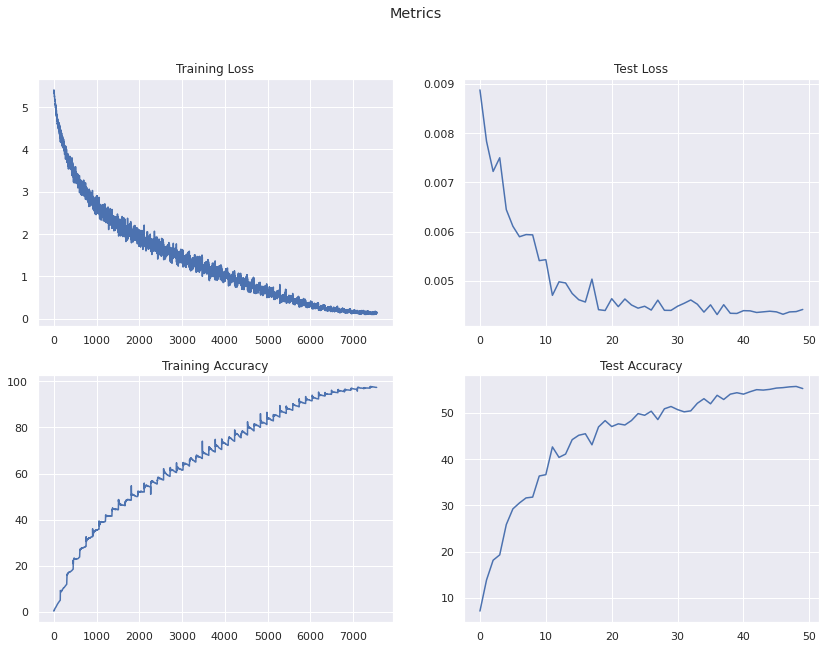

In [ ]:
train_metric = (train_acc, train_losses)
test_metric = (test_acc, test_losses)

plot_metrics.metrics(train_metric, test_metric)